In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('mode.chained_assignment', None)

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

## Exemplo dos dados das empresas

Dados de doze empresas e 3 variáveis - exemplo de MINGOTI (2005). Vamos criar o *dataframe* usando a função *DataFrame* do *pandas*. Poderíamos também ter os dados salvos em uma planilha e usar a função *read_csv* para lê-la.

In [2]:
# ganho bruto - B (X1)
# ganho líquido - L (X2)
# patrimônio acumulado - P (X3)
dados = pd.DataFrame({'B': [9893,8776,13572,6455,5129,5432,3807,3423,3708,3294,5433,6287],
                  'L': [564,389,1103,743,203,215,385,187,127,297,432,451],
                  'P': [17689,17359,18597,8745,14397,3467,4679,6754,2275,6754,5589,8972]})
dados.head()

,B,L,P
0,9893,564,17689
1,8776,389,17359
2,13572,1103,18597
3,6455,743,8745
4,5129,203,14397


#### ACP usando a matriz de correlações

In [3]:
X = dados

In [4]:
pca = PCA() 
resultado_pca = pca.fit_transform(scale(X))   # scale(X) padroniza os dados, como se usássemos a matriz R

In [5]:
resultado = pd.DataFrame({'cp1': resultado_pca[:, 0], 'cp2': resultado_pca[:, 1]})

In [6]:
# coeficientes dos CPs (autovetores)
# cada linha é um CP
pca.components_

array([[ 0.61670267,  0.55679445,  0.556469  ],
       [-0.00126721, -0.70619694,  0.70801432],
       [ 0.78719515, -0.43733949, -0.43480796]])

Interpretação:

- Y1: índice de desempenho global da empresa (valores altos positivos indicam empresas que tiveram ganhos B, L e P maiores do que a média)
- Y2: comparação entre L e P (valores ~ 0 indicam empresas em que L está em equilíbrio com P)
- Y3: comparação de B com o índice composto por por L e P (representa pouco da variação total, mas pode ser de interesse para o pesquisador)

In [7]:
# variâncias dos CPs (autovalores)
pca.explained_variance_

array([ 2.71912594,  0.46199796,  0.09160337])

De acordo com o critério de apenas escolher autovalores maiores do que 1, apenas o primeiro CP seria considerado.

In [8]:
# variância explicada acumulada
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([  83.08,   97.2 ,  100.  ])

Pelo critério de explicação de cerca de 70%, apenas o primeiro CP seria considerado.

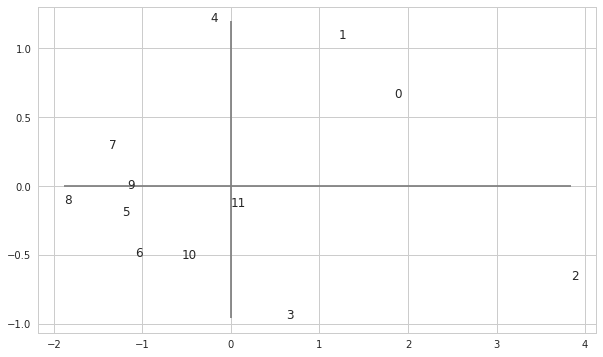

In [10]:
# diagrama de dispersão dos escores dos dois primeiros CPs
# rótulos: os índices das empresas
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.scatter(resultado.cp1, resultado.cp2, s=0)
for i, txt in enumerate(resultado.index):
    ax.annotate(txt, (resultado.cp1[i], resultado.cp2[i]))
plt.hlines(0, resultado['cp1'].min(), resultado['cp1'].max(), color='gray')
plt.vlines(0, resultado['cp2'].min(), resultado['cp2'].max(), color='gray');

## Selecionar componentes principais

In [11]:
tot = sum(pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([  83.08440382,   97.20100811,  100.        ])

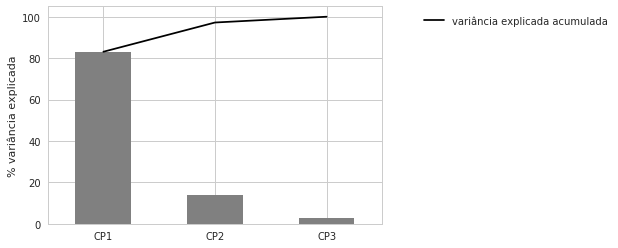

In [12]:
# número de CPs gerados (k = p)
cp =['CP'+str(i+1) for i in range(len(pca.components_))]
df = pd.DataFrame({'cp': cp, 'var_exp': var_exp, 'cum_var_exp': cum_var_exp})
# scree plot
fig, ax = plt.subplots()
df.plot.bar('cp', 'var_exp', color='gray', ax=ax, legend=False)
df.plot.line('cp', 'cum_var_exp', color='black', ax=ax)
plt.legend(labels=['variância explicada acumulada'],
           loc='upper right', 
           bbox_to_anchor=(1.7, 1))
plt.ylabel('% variância explicada')
plt.xlabel('');

Os dois primeiros CPs explicam 97% da variação total. Ficaremos com os dois primeiros para poder fazer o diagrama de dispersão. Mas poderíamos ficar apenas com o primeiro.

### Análise de agrupamento

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [14]:
X = dados

A distância de Mahalanobis poderá ser utilizada, menos para os métodos do centróide e de Ward. Para utilizar a distância de Mahalanobis:

In [15]:
# agrupamento usando a distância média e distância de Mahalanobis no lugar da euclidiana

# Z = linkage(X, method='average', metric='mahalanobis')

In [16]:
# usando a distância euclidiana como métrica
# aqui usei Ward, mas todos os métodos vistos devem ser testados
Z = linkage(X, method='ward')
# method='single' (vizinho + próximo)
# 'complete' (vizinho + distante)
# 'average' (distância média)
# 'centroid' 
# 'ward'

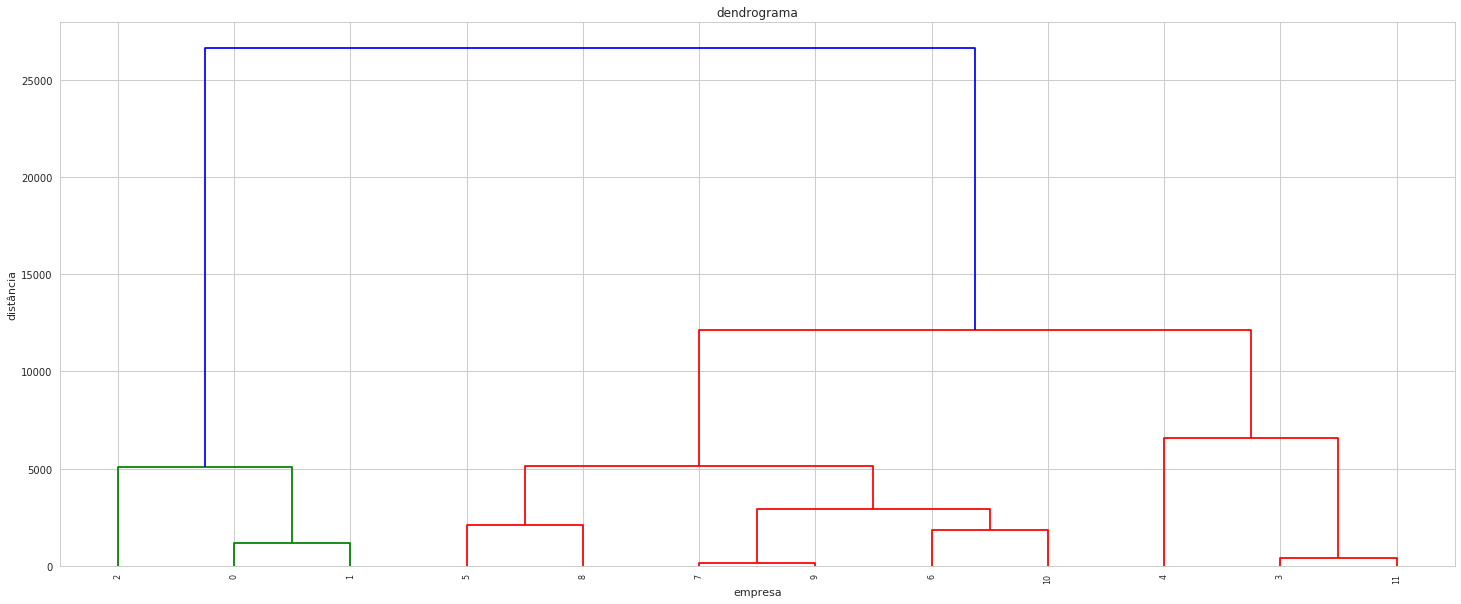

In [17]:
# método escolhido na célula anterior
# obter o dendrograma de forma mais automática - função dendrogram
plt.figure(figsize=(25, 10))
plt.title('dendrograma')
plt.xlabel('empresa')
plt.ylabel('distância')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotação do eixo
    leaf_font_size=8.,  # tamanho da fonte
)
plt.show()

In [18]:
# definir a distância de corte baseando no dendrograma
max_d = 9000

In [19]:
# escolher o número de grupos baseando-se no dendrograma

k = 3

In [20]:
# lista com os grupos referentes às observações
from scipy.cluster.hierarchy import cut_tree
grupos = cut_tree(Z, n_clusters=[k])

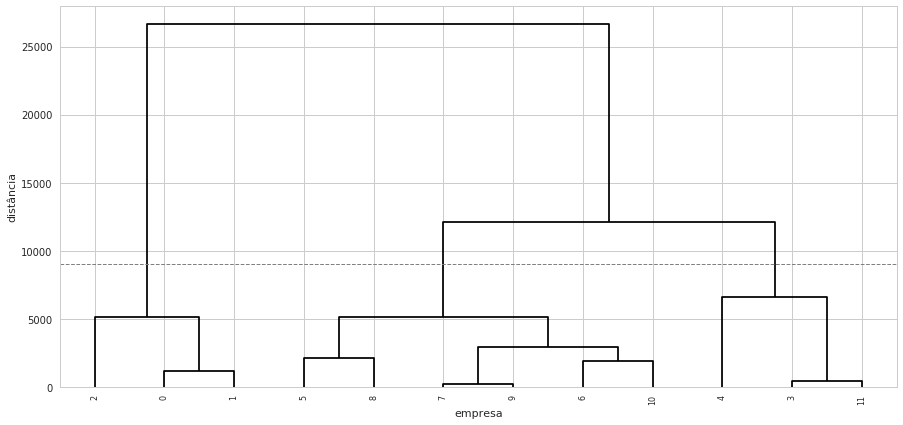

In [21]:
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=40,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('empresa')
plt.ylabel('distância');

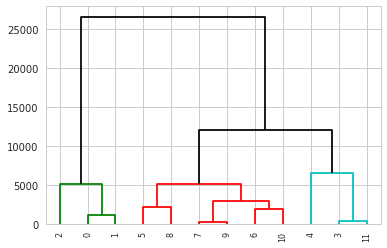

In [22]:
# com cores dos grupos
a = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=40,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=max_d, # para que os grupos fiquem com cores diferentes
);

In [23]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos
resultado['grupo'] = grupos
resultado.shape

(12, 3)

In [24]:
# contagem de observações em cada grupo
resultado.grupo.value_counts()

2    6
1    3
0    3
Name: grupo, dtype: int64

In [25]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados['grupo'] = grupos
dados.head()

,B,L,P,grupo
0,9893,564,17689,0
1,8776,389,17359,0
2,13572,1103,18597,0
3,6455,743,8745,1
4,5129,203,14397,1


## Análise dos grupos

In [26]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados.groupby('grupo').mean()

,B,L,P
grupo,,,
0,10747.000000,685.333333,17881.666667
1,5957.000000,465.666667,10704.666667
2,4182.833333,273.833333,4919.666667


In [27]:
# mediana das variáveis para cada grupo
dados.groupby('grupo').median()

,B,L,P
grupo,,,
0,9893.0,564.0,17689.0
1,6287.0,451.0,8972.0
2,3757.5,256.0,5134.0


Avaliação dos grupos em relação às variáveis:

- grupo 0: são as empresas com maiores ganhos bruto e líquido, além de possuírem maior patrimônio
- grupo 1: valores intermediários para todas as variáveis
- grupo 2: menores valores para as três variáveis

In [28]:
# desvio padrão
dados.groupby('grupo').std()

,B,L,P
grupo,,,
0,2509.460301,372.142894,641.093857
1,721.972299,270.298600,3199.668160
2,985.639167,118.720540,1807.760345


## As observações de cada grupo

In [29]:
grupo0 = dados.query('grupo == 0').index
pd.DataFrame(list(grupo0))

,0
0,0
1,1
2,2


In [30]:
grupo1 = dados.query('grupo == 1').index
pd.DataFrame(list(grupo1))

,0
0,3
1,4
2,11


In [31]:
grupo2 = dados.query('grupo == 2').index
pd.DataFrame(list(grupo2))

,0
0,5
1,6
2,7
3,8
4,9
5,10


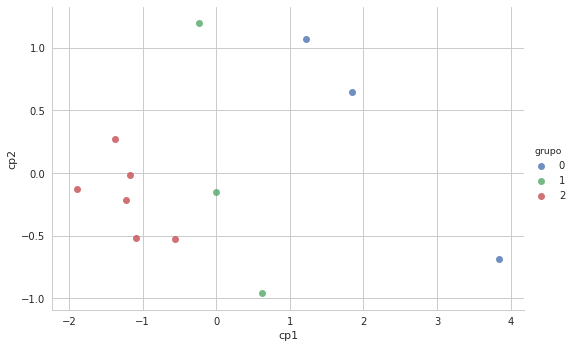

In [32]:
# plotar os escores dos CPs dos 3 grupos
sns.lmplot('cp1', 'cp2', hue='grupo', fit_reg=False, data=resultado, aspect=1.5);

In [33]:
# incluir o identificador da empresa no dataframe 'resultado'
resultado['empresa'] = resultado.index

In [34]:
# pacote altair para fazer outros tipos de gráficos
# usaremos para o diagrama de dispersão com a cor de acordo com a mesorregião
import altair as alt
alt.renderers.enable('notebook');
# pacote para ter mais opções de paletas de cores
import palettable
# https://vega.github.io/vega/docs/schemes/#reference

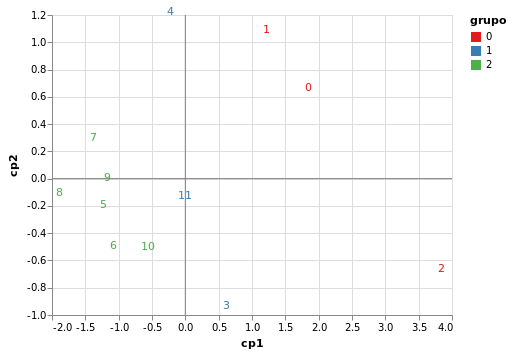

In [35]:
# gráficos
g = alt.Chart(resultado).mark_text().encode(
    alt.X('cp1', scale=alt.Scale(domain=[resultado['cp1'].min(), resultado['cp1'].max()]), axis=alt.Axis(title='cp1')),
    alt.Y('cp2', scale=alt.Scale(domain=[resultado['cp2'].min(), resultado['cp2'].max()]), axis=alt.Axis(title='cp2')),
    text='empresa',
    color=alt.Color('grupo:O', scale=alt.Scale(scheme='set1'))
)
# eixo x = 0
bar_x = alt.Chart(resultado).mark_rule(color='gray').encode(
    x='mean(0):Q')

# eixo y = 0
bar_y = alt.Chart(resultado).mark_rule(color='gray').encode(
    y='mean(0):Q')


g + bar_x + bar_y

Se uma nova análise for feita usando a distância de Mahalanobis, alguns dos métodos de agrupamento deixarão a observação 2 num grupo separado. 

### k-médias

Como é preciso decidir o número de grupos antes de aplicar o método das *k*-médias, usaremos como critério o número de grupos definido a partir da observação do dendrograma.

In [36]:
# número de grupos sugerido pelo dendrograma
k = 3

In [37]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)

In [38]:
kmeans.labels_

array([0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2], dtype=int32)

In [39]:
# kmeans.cluster_centers_

In [40]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos
resultado['grupo'] = kmeans.labels_

In [41]:
resultado.shape

(12, 4)

In [42]:
resultado.head()

,cp1,cp2,grupo,empresa
0,1.849933,0.645271,0,0
1,1.215910,1.071540,0,1
2,3.841723,-0.681407,0,2
3,0.624086,-0.958889,2,3
4,-0.229387,1.196460,2,4


In [43]:
resultado.grupo.value_counts()

1    6
2    3
0    3
Name: grupo, dtype: int64

In [44]:
# incluir no dataframe de dados as informações sobre a qual grupo cada município pertence
dados['grupo'] = kmeans.labels_
dados.head()

,B,L,P,grupo
0,9893,564,17689,0
1,8776,389,17359,0
2,13572,1103,18597,0
3,6455,743,8745,2
4,5129,203,14397,2


In [45]:
# média dos grupos
dados.groupby('grupo').mean()

,B,L,P
grupo,,,
0,10747.000000,685.333333,17881.666667
1,4182.833333,273.833333,4919.666667
2,5957.000000,465.666667,10704.666667


In [46]:
# mediana das variáveis para cada grupo
dados.groupby('grupo').median()

,B,L,P
grupo,,,
0,9893.0,564.0,17689.0
1,3757.5,256.0,5134.0
2,6287.0,451.0,8972.0


Interpretação parecida com a que ocorreu no método de Ward.

In [47]:
# desvio padrão
dados.groupby('grupo').std()

,B,L,P
grupo,,,
0,2509.460301,372.142894,641.093857
1,985.639167,118.720540,1807.760345
2,721.972299,270.298600,3199.668160


## As observações de cada grupo

In [48]:
grupo0 = dados.query('grupo == 0').index
pd.DataFrame(list(grupo0))

,0
0,0
1,1
2,2


In [49]:
grupo1 = dados.query('grupo == 1').index
pd.DataFrame(list(grupo1))

,0
0,5
1,6
2,7
3,8
4,9
5,10


In [50]:
grupo2 = dados.query('grupo == 2').index
pd.DataFrame(list(grupo2))

,0
0,3
1,4
2,11


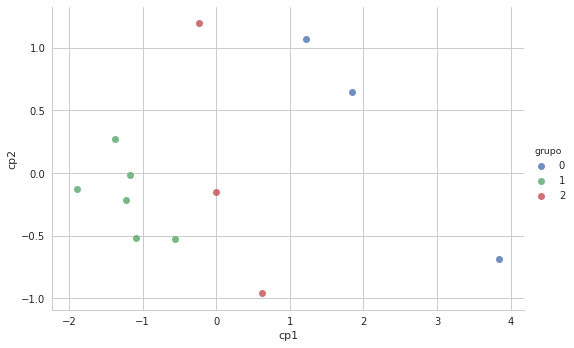

In [51]:
# plotar os escores dos CPs dos 3 grupos
sns.lmplot('cp1', 'cp2', hue='grupo', fit_reg=False, data=resultado, aspect=1.5);

In [52]:
resultado['empresa'] = resultado.index

In [53]:
# pacote altair para fazer outros tipos de gráficos
# usaremos para o diagrama de dispersão com a cor de acordo com a mesorregião
import altair as alt
alt.renderers.enable('notebook');
import palettable
# https://vega.github.io/vega/docs/schemes/#reference

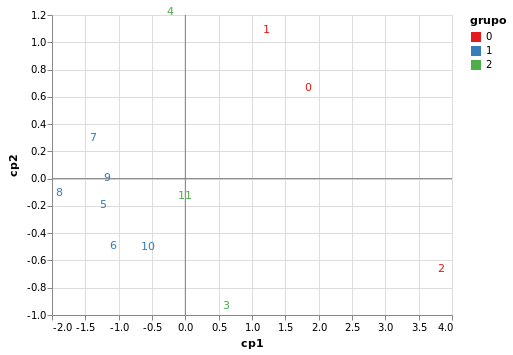

In [55]:
# gráficos
g = alt.Chart(resultado).mark_text().encode(
    alt.X('cp1', scale=alt.Scale(domain=[resultado['cp1'].min(), resultado['cp1'].max()]), axis=alt.Axis(title='cp1')),
    alt.Y('cp2', scale=alt.Scale(domain=[resultado['cp2'].min(), resultado['cp2'].max()]), axis=alt.Axis(title='cp2')),
    text='empresa',
    color=alt.Color('grupo:O', scale=alt.Scale(scheme='set1'))
)
# eixo x = 0
bar = alt.Chart(resultado).mark_rule(color='gray').encode(
    x='mean(0):Q')

# eixo y = 0
bar1 = alt.Chart(resultado).mark_rule(color='gray').encode(
    y='mean(0):Q')


g + bar + bar1

Agrupamentos muito próximos dos que foram obtidos com o método de Ward.

### Gráfico k x SQDG

Auxilia a decidir em quantos grupos dividir os dados usando o método das $k$-médias. Procurar pelo 'cotovelo' (ponto a partir do qual a queda da SQDG é menor).

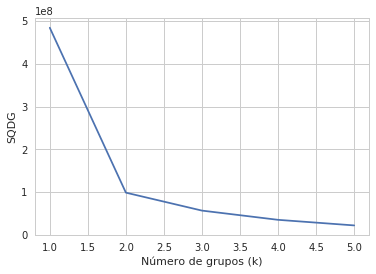

In [56]:
# SQDG
SQDG = {}
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados)
    dados['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

Por meio desse gráfico seria aceitável dizer que temos 2 ou 3 grupos.

## *Silhouette plot*

https://github.com/scikit-learn/scikit-learn/blob/master/examples/cluster/plot_kmeans_silhouette_analysis.py


A análise de silhueta pode ser usada para estudar a distância de separação entre os grupos formados. O *silhouette plot* mostra uma medida de quão próximo cada observação de um grupo está de observações nos grupos vizinhos. Dessa forma, ele possibilita uma forma de avaliar o número de grupos. A medida 'silhueta' apresenta valores no intervalo $[-1, 1]$.

Coeficientes de silhueta próximos de $+1$ indicam que a observação está bem distante dos grupos vizinhos. Valores próximos de $0$ indicam que a observação está muito próxima do limite de decisão entre dois grupos vizinhos. Já valores próximos de $-1$ indicam que as observações possam ter sido atribuídas ao grupo incorreto. 

Para o exemplo das empresas queremos encontrar o valor ótimo de $k$ e testaremos valores de 2 a 5 grupos.

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [58]:
# chamando os dados de X para facilitar
X = dados

Para k =  2 Valor do escore médio: 0.657897897398
Para k =  3 Valor do escore médio: 0.511257767095
Para k =  4 Valor do escore médio: 0.474844307148
Para k =  5 Valor do escore médio: 0.45568521435


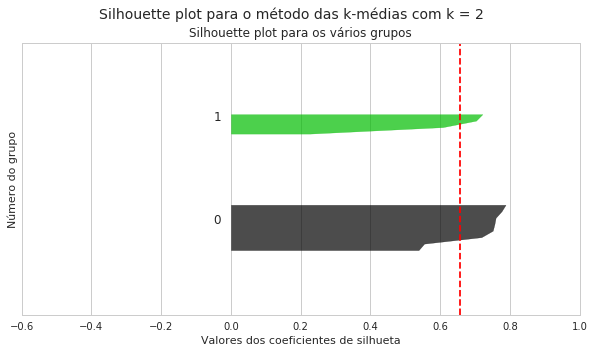

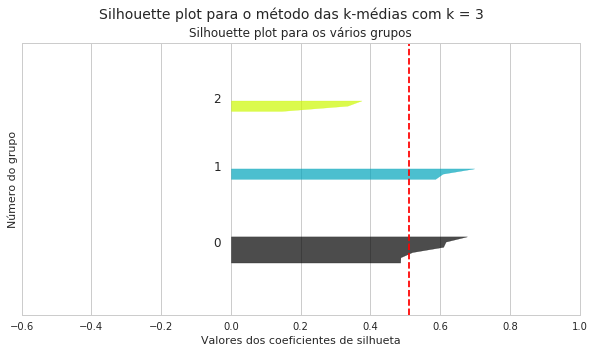

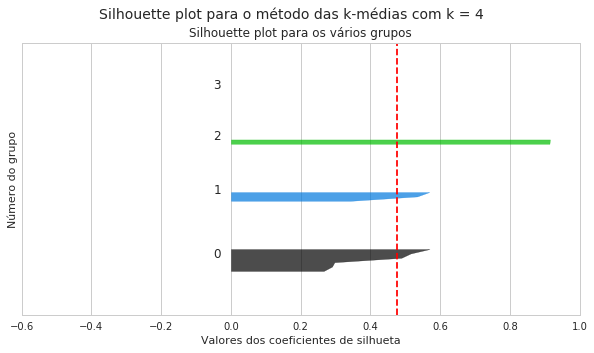

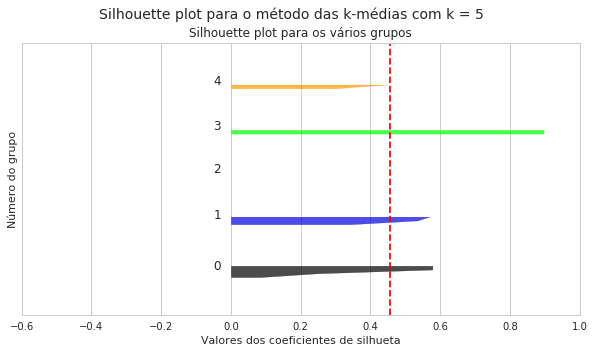

In [59]:
# testando de 2 a 5 grupos
range_n_clusters = list(range(2, 6))
for n_clusters in range_n_clusters:
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 5)

    ax1.set_xlim([-0.5, 1])
    # inserir espaços em branco entre os gráficos
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # valores iniciais aleatórios (10 valores) 
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # o escore dá a média do valor silhueta para todas as amostras
    silhouette_avg = silhouette_score(X, cluster_labels)
    print('Para k = ', n_clusters,
          'Valor do escore médio:', silhouette_avg)

    # calcula os valores dos coeficientes para todas as observações
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # une os escores de silhueta para observações pertencendo ao 
        # grupo i e ordena
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # nomeia os gráficos com seus números de grupos
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # calcula novo valor de y para o próximo gráfico
        y_lower = y_upper + 10

    ax1.set_title('Silhouette plot para os vários grupos')
    ax1.set_xlabel('Valores dos coeficientes de silhueta')
    ax1.set_ylabel('Número do grupo')

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax1.set_yticks([])  # limpa os rótulos dos eixos
    ax1.set_xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(('Silhouette plot para o método das k-médias'
                  ' com k = %d' % n_clusters), fontsize=14);

No exemplo das empresas, a escolha de $k = 2$ e $k = 3$ talvez seriam as melhores, já que os coeficientes estão próximos da média em todos os grupos. Para $k = 2$ percebe-se que o grupo  0 possui mais observações do que o grupo 1, mas isso não é necessariamente ruim. Para $k = 3$ os grupos estão mais balanceados em relação ao número de observações e em relação aos valores dos coeficientes.

Para $k = 4$ e $k = 5$ há maior desbalanceamento nos escores dos grupos formados. Por exemplo, para $k = 5$, o grupo $2$ possui coeficiente próximo de 0, o que significa que essa observação ficou no limite de decisão de estar em dois grupos diferentes.

Assim, seria interessante voltar na análise e agrupar com $k = 2$, que foi uma boa escolha, e verificar como se comportaram os agrupamentos.

### Exemplo de MG - imrs

In [60]:
dados = pd.read_excel('/home/patricia/drive/unifal/analise_multivariada/2018_1/trabalho/imrs-resumido-2016.xlsx', index_col='mun')

In [61]:
dados.head()

,ibge7,popul,rdpc_formal,tx_mort,prop_priv_saude
mun,,,,,
Abadia dos Dourados,3100104,7037,540.70,4.55,15.32
Abaeté,3100203,23574,258.94,6.32,14.01
Abre Campo,3100302,13726,152.43,7.07,4.26
Acaiaca,3100401,4061,132.16,5.17,6.06
Açucena,3100500,10066,59.31,7.45,9.40


In [62]:
# dados2: incluir código para usar depois
dados2 = dados
# resultado2 = resultado.reset_index()
cod = pd.read_csv('/home/patricia/drive/unifal/analise_multivariada/2018_1/trabalho/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.rename(columns={'mun': 'ibge7'}, inplace=True)
dados2 = dados2.merge(cod)

In [63]:
dados2.head()

,ibge7,popul,rdpc_formal,tx_mort,prop_priv_saude,nome_mun,nome_meso
0,3100104,7037,540.70,4.55,15.32,Abadia dos Dourados,Triângulo Mineiro/Alto Paranaíba
1,3100203,23574,258.94,6.32,14.01,Abaeté,Central Mineira
2,3100302,13726,152.43,7.07,4.26,Abre Campo,Zona da Mata
3,3100401,4061,132.16,5.17,6.06,Acaiaca,Zona da Mata
4,3100500,10066,59.31,7.45,9.40,Açucena,Vale do Rio Doce


In [64]:
# verificar se tem algum valor faltante
dados.isnull().any()

ibge7              False
popul              False
rdpc_formal        False
tx_mort            False
prop_priv_saude    False
dtype: bool

In [65]:
dados.iloc[:,1:6].describe()

,popul,rdpc_formal,tx_mort,prop_priv_saude
count,8.530000e+02,853.000000,853.000000,853.000000
mean,2.461613e+04,224.721923,6.817280,10.074572
std,1.000713e+05,229.002939,1.633406,10.319930
min,8.150000e+02,21.400000,1.450000,0.080000
25%,4.940000e+03,104.560000,5.750000,2.660000
50%,8.283000e+03,169.790000,6.750000,6.220000
75%,1.803600e+04,262.320000,7.740000,14.260000
max,2.513451e+06,3296.670000,16.520000,68.290000


In [66]:
# médias
dados.iloc[:,1:6].mean()

popul              24616.131301
rdpc_formal          224.721923
tx_mort                6.817280
prop_priv_saude       10.074572
dtype: float64

In [67]:
dados.iloc[:,1:6].cov()

,popul,rdpc_formal,tx_mort,prop_priv_saude
popul,1.001427e+10,7.185591e+06,-9804.940018,352040.644352
rdpc_formal,7.185591e+06,5.244235e+04,-20.524976,1367.664141
tx_mort,-9.804940e+03,-2.052498e+01,2.668014,-0.237378
prop_priv_saude,3.520406e+05,1.367664e+03,-0.237378,106.500946


In [68]:
dados.iloc[:,1:6].corr()

,popul,rdpc_formal,tx_mort,prop_priv_saude
popul,1.000000,0.313554,-0.059985,0.340884
rdpc_formal,0.313554,1.000000,-0.054872,0.578711
tx_mort,-0.059985,-0.054872,1.000000,-0.014082
prop_priv_saude,0.340884,0.578711,-0.014082,1.000000


In [69]:
dados.columns

Index(['ibge7', 'popul', 'rdpc_formal', 'tx_mort', 'prop_priv_saude'], dtype='object')

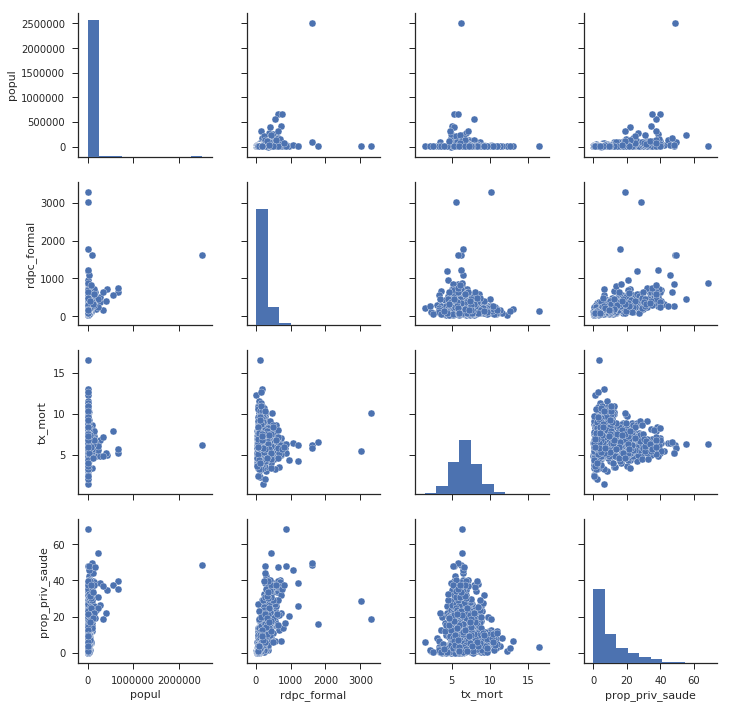

In [70]:
sns.set(style='ticks')
sns.pairplot(dados.iloc[:,1:11]);

### ACP

In [71]:
# subselecionar variáveis
X = dados.iloc[:,1:5]

In [72]:
pca = PCA() 
resultado_pca = pca.fit_transform(scale(X))   # scale(X) padroniza os dados, como se usássemos a matriz R

In [73]:
resultado = pd.DataFrame({'cp1': resultado_pca[:, 0], 'cp2': resultado_pca[:, 1]}, index=dados.index)

In [74]:
# coeficientes dos CPs (autovetores)
# cada linha é um CP
pca.components_

array([[ 0.48493896,  0.61202337, -0.08485521,  0.61891938],
       [-0.05430099,  0.05573001,  0.98934188,  0.12307807],
       [ 0.87118714, -0.38007152,  0.10558684, -0.29228417],
       [ 0.05402394,  0.69127939,  0.05341962, -0.71858232]])

Interpretação:

- $Y_1$: quanto maior o escore positivo, maiores: tamanho da população, rendimento do setor formal e % de planos de saúde.
- $Y_2$: mais influenciado pela taxa de mortalidade. Quanto maior o escore positivo, maior a taxa de mortalidade. 

In [75]:
# variâncias dos CPs (autovalores)
pca.explained_variance_

array([ 1.84344578,  0.9996214 ,  0.74243991,  0.41918775])

De acordo com o critério de apenas escolher autovalores maiores do que 1, os dois primeiros CPs seriam considerados.

In [76]:
# variância explicada acumulada
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([  46.03,   70.99,   89.53,  100.  ])

Pelo critério de explicação de cerca de 70% seriam também os dois primeiros.

In [77]:
# escores dos dois primeiros CPs
resultado.head()

,cp1,cp2
mun,,
Abadia dos Dourados,1.192351,-1.225000
Abaeté,0.348458,-0.245515
Abre Campo,-0.608181,0.072083
Acaiaca,-0.502471,-1.057617
Açucena,-0.586251,0.343030


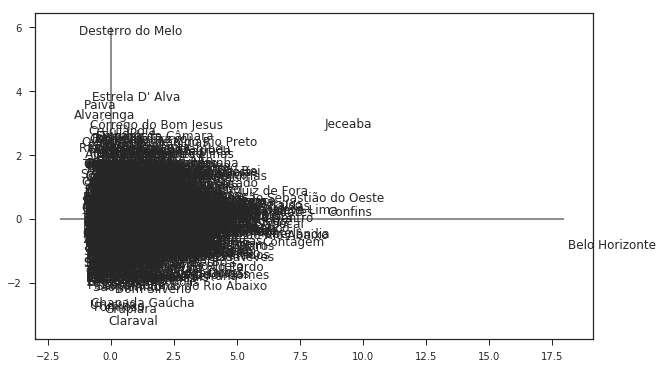

In [78]:
# diagrama de dispersão dos escores dos dois primeiros CPs
# rótulos: os índices das empresas
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.scatter(resultado.cp1, resultado.cp2, s=0)
for i, txt in enumerate(resultado.index):
    ax.annotate(txt, (resultado.cp1[i], resultado.cp2[i]))
plt.hlines(0, -2, 18, color='gray')
plt.vlines(0, -2, 6, color='gray');

## Selecionar componentes principais

In [79]:
tot = sum(pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([ 46.03211628,  70.99335399,  89.53259196, 100.        ])

In [80]:
# número de CPs gerados (k = p)
cp =['CP'+str(i+1) for i in range(len(pca.components_))]
cp

['CP1', 'CP2', 'CP3', 'CP4']

In [81]:
df = pd.DataFrame({'cp': cp, 'var_exp': var_exp, 'cum_var_exp': cum_var_exp})
df

,cp,var_exp,cum_var_exp
0,CP1,46.032116,46.032116
1,CP2,24.961238,70.993354
2,CP3,18.539238,89.532592
3,CP4,10.467408,100.000000


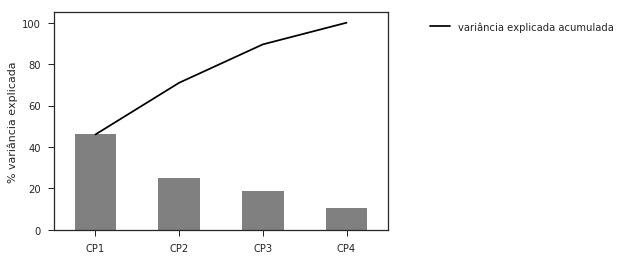

In [82]:
# scree plot
fig, ax = plt.subplots()
df.plot.bar('cp', 'var_exp', color='gray', ax=ax, legend=False)
df.plot.line('cp', 'cum_var_exp', color='black', ax=ax)
plt.legend(labels=['variância explicada acumulada'],
           loc='upper right', 
           bbox_to_anchor=(1.7, 1))
plt.ylabel('% variância explicada')
plt.xlabel('');

Os dois primeiros CPs explicam 71% da variação total. Ficaremos com os dois primeiros.

### Análise de agrupamento

In [83]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [84]:
X = dados

### Questão 4. a) 

Use a distância de Mahalanobis e o método da ligação média. O resultado foi muito diferente do método da ligação média usando a distância euclidiana?


In [85]:
# agrupamento usando a ligação média e distância de Mahalanobis no lugar da euclidiana

# Z = linkage(X, method='average', metric='mahalanobis')

In [86]:
# usando a distância euclidiana como métrica
# aqui usei Ward, mas todos os métodos vistos devem ser testados
Z = linkage(X, method='ward')
# method='single' (vizinho + próximo)
# 'complete' (vizinho + distante)
# 'average' (distância média)
# 'centroid' 
# 'ward'

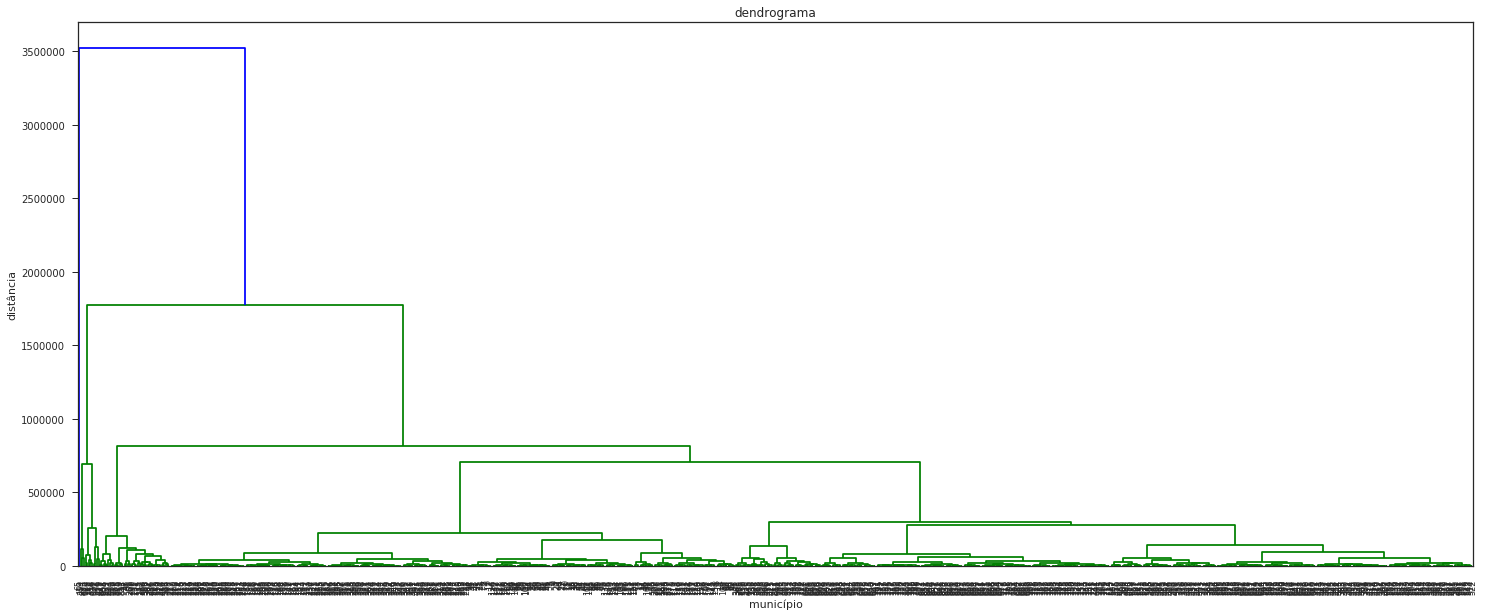

In [87]:
# método escolhido na célula anterior
# obter o dendrograma de forma mais automática - função dendrogram
plt.figure(figsize=(25, 10))
plt.title('dendrograma')
plt.xlabel('município')
plt.ylabel('distância')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotação do eixo
    leaf_font_size=8.,  # tamanho da fonte
)
plt.show()

In [88]:
# definir a distância de corte baseando no dendrograma
max_d = 1000000

In [89]:
# escolher o número de grupos baseando-se no dendrograma

k = 3

In [90]:
# lista com os grupos referentes às observações
from scipy.cluster.hierarchy import cut_tree
grupos = cut_tree(Z, n_clusters=[k])

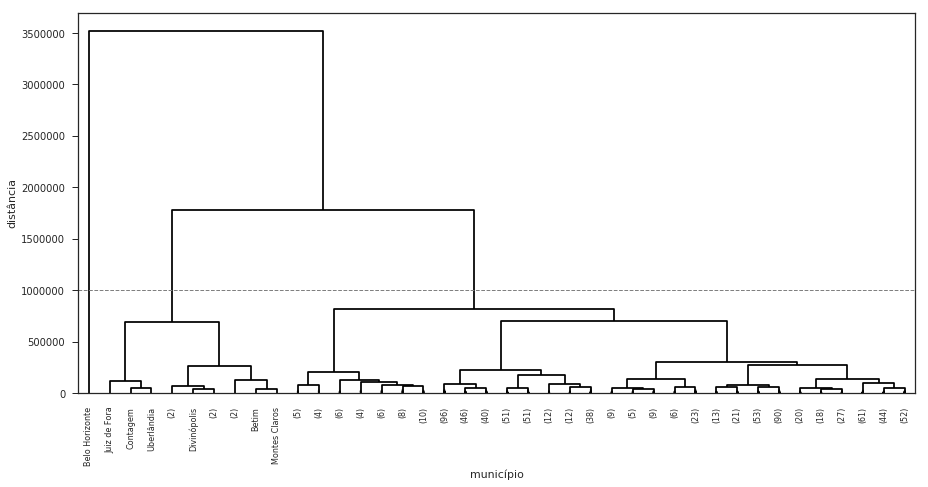

In [94]:
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=40,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

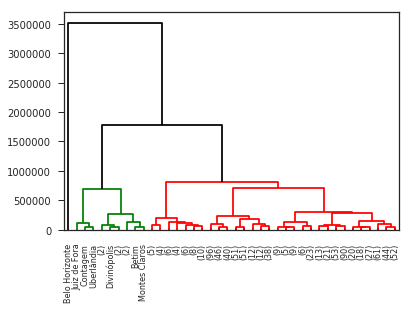

In [95]:
# com cores dos grupos
a = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=40,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=max_d, # para que os grupos fiquem com cores diferentes
);

In [96]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos
resultado['grupo'] = grupos
resultado.shape

(853, 3)

In [97]:
# contagem de observações em cada grupo
resultado.grupo.value_counts()

0    840
2     12
1      1
Name: grupo, dtype: int64

In [98]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados['grupo'] = grupos
dados.head()

,ibge7,popul,rdpc_formal,tx_mort,prop_priv_saude,grupo
mun,,,,,,
Abadia dos Dourados,3100104,7037,540.70,4.55,15.32,0
Abaeté,3100203,23574,258.94,6.32,14.01,0
Abre Campo,3100302,13726,152.43,7.07,4.26,0
Acaiaca,3100401,4061,132.16,5.17,6.06,0
Açucena,3100500,10066,59.31,7.45,9.40,0


## Análise dos grupos

In [99]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados.iloc[:,1:6].groupby('grupo').mean()

,popul,rdpc_formal,tx_mort,prop_priv_saude
grupo,,,,
0,1.655413e+04,219.283571,6.831095,9.694667
1,2.513451e+06,1612.500000,6.180000,48.640000
2,3.815533e+05,489.758333,5.903333,33.454167


In [100]:
# mediana das variáveis para cada grupo
dados.iloc[:,1:6].groupby('grupo').median()

,popul,rdpc_formal,tx_mort,prop_priv_saude
grupo,,,,
0,8089.5,165.740,6.760,6.105
1,2513451.0,1612.500,6.180,48.640
2,325562.5,477.425,5.655,34.970


Avaliação dos grupos em relação às variáveis:

- grupo 0: municípios pequenos, de renda mais baixa, taxa de mortalidade mais alta e baixa proporção de pessoas com planos de saúde privado
- grupo 1: apenas BH. Município grande, alta rendae alta proporção de planos de saúde
- grupo 2: municípios com valores intermediários para as variráveis, exceto para a mortalidade, que é mais baixa

In [101]:
# desvio padrão
dados.iloc[:,1:6].groupby('grupo').std()

,popul,rdpc_formal,tx_mort,prop_priv_saude
grupo,,,,
0,23449.976232,222.460655,1.638320,9.856076
1,NaN,NaN,NaN,NaN
2,163220.100403,182.438154,0.981857,9.856633


## As observações de cada grupo

In [102]:
grupo0 = dados.query('grupo == 0').index
pd.DataFrame(list(grupo0))

,0
0,Abadia dos Dourados
1,Abaeté
2,Abre Campo
3,Acaiaca
4,Açucena
5,Água Boa
6,Água Comprida
7,Aguanil
8,Águas Formosas
9,Águas Vermelhas


In [103]:
grupo1 = dados.query('grupo == 1').index
pd.DataFrame(list(grupo1))

,0
0,Belo Horizonte


In [104]:
grupo2 = dados.query('grupo == 2').index
pd.DataFrame(list(grupo2))

,0
0,Betim
1,Contagem
2,Divinópolis
3,Governador Valadares
4,Ipatinga
5,Juiz de Fora
6,Montes Claros
7,Ribeirão das Neves
8,Santa Luzia
9,Sete Lagoas


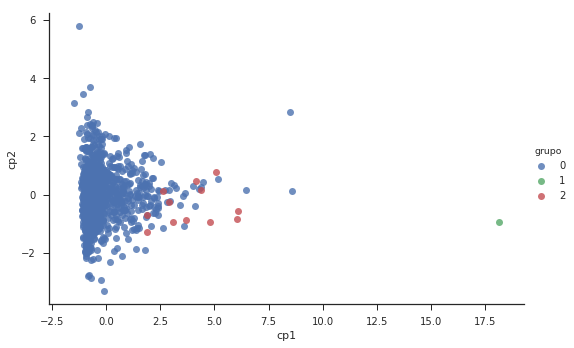

In [105]:
# plotar os escores dos CPs dos 3 grupos
sns.lmplot('cp1', 'cp2', hue='grupo', fit_reg=False, data=resultado, aspect=1.5);

In [106]:
# incluir o identificador da empresa no dataframe 'resultado'
resultado['muni'] = resultado.index

In [107]:
# pacote altair para fazer outros tipos de gráficos
# usaremos para o diagrama de dispersão com a cor de acordo com a mesorregião
import altair as alt
alt.renderers.enable('notebook');
# pacote para ter mais opções de paletas de cores
import palettable
# https://vega.github.io/vega/docs/schemes/#reference

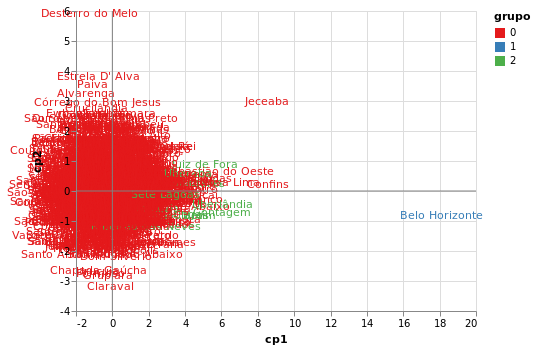

In [108]:
# gráficos
g = alt.Chart(resultado).mark_text().encode(
    alt.X('cp1', scale=alt.Scale(domain=[resultado['cp1'].min(), resultado['cp1'].max()]), axis=alt.Axis(title='cp1')),
    alt.Y('cp2', scale=alt.Scale(domain=[resultado['cp2'].min(), resultado['cp2'].max()]), axis=alt.Axis(title='cp2')),
    text='muni',
    color=alt.Color('grupo:O', scale=alt.Scale(scheme='set1'))
)
# eixo x = 0
bar_x = alt.Chart(resultado).mark_rule(color='gray').encode(
    x='mean(0):Q')

# eixo y = 0
bar_y = alt.Chart(resultado).mark_rule(color='gray').encode(
    y='mean(0):Q')


g + bar_x + bar_y

### k-médias

Como é preciso decidir o número de grupos antes de aplicar o método das *k*-médias, usaremos como critério o número de grupos definido a partir da observação do dendrograma.

In [109]:
# número de grupos sugerido pelo dendrograma
k = 3

In [110]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)

In [111]:
# kmeans.labels_

In [112]:
# kmeans.cluster_centers_

In [113]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos
resultado['grupo'] = kmeans.labels_

In [114]:
resultado.shape

(853, 4)

In [115]:
resultado.head()

,cp1,cp2,grupo,muni
mun,,,,
Abadia dos Dourados,1.192351,-1.225000,0,Abadia dos Dourados
Abaeté,0.348458,-0.245515,0,Abaeté
Abre Campo,-0.608181,0.072083,0,Abre Campo
Acaiaca,-0.502471,-1.057617,0,Acaiaca
Açucena,-0.586251,0.343030,0,Açucena


In [116]:
resultado.grupo.value_counts()

0    840
2     12
1      1
Name: grupo, dtype: int64

In [117]:
# incluir no dataframe de dados as informações sobre a qual grupo cada município pertence
dados['grupo'] = kmeans.labels_
dados.head()

,ibge7,popul,rdpc_formal,tx_mort,prop_priv_saude,grupo
mun,,,,,,
Abadia dos Dourados,3100104,7037,540.70,4.55,15.32,0
Abaeté,3100203,23574,258.94,6.32,14.01,0
Abre Campo,3100302,13726,152.43,7.07,4.26,0
Acaiaca,3100401,4061,132.16,5.17,6.06,0
Açucena,3100500,10066,59.31,7.45,9.40,0


In [118]:
# média dos grupos
dados.iloc[:,1:6].groupby('grupo').mean()

,popul,rdpc_formal,tx_mort,prop_priv_saude
grupo,,,,
0,1.655413e+04,219.283571,6.831095,9.694667
1,2.513451e+06,1612.500000,6.180000,48.640000
2,3.815533e+05,489.758333,5.903333,33.454167


In [119]:
# mediana das variáveis para cada grupo
dados.iloc[:,1:6].groupby('grupo').median()

,popul,rdpc_formal,tx_mort,prop_priv_saude
grupo,,,,
0,8089.5,165.740,6.760,6.105
1,2513451.0,1612.500,6.180,48.640
2,325562.5,477.425,5.655,34.970


Interpretação parecida com a que ocorreu no método de Ward.

In [120]:
# desvio padrão
dados.iloc[:,1:6].groupby('grupo').std()

,popul,rdpc_formal,tx_mort,prop_priv_saude
grupo,,,,
0,23449.976232,222.460655,1.638320,9.856076
1,NaN,NaN,NaN,NaN
2,163220.100403,182.438154,0.981857,9.856633


## As observações de cada grupo

In [121]:
grupo0 = dados.query('grupo == 0').index
pd.DataFrame(list(grupo0))

,0
0,Abadia dos Dourados
1,Abaeté
2,Abre Campo
3,Acaiaca
4,Açucena
5,Água Boa
6,Água Comprida
7,Aguanil
8,Águas Formosas
9,Águas Vermelhas


In [122]:
grupo1 = dados.query('grupo == 1').index
pd.DataFrame(list(grupo1))

,0
0,Belo Horizonte


In [123]:
grupo2 = dados.query('grupo == 2').index
pd.DataFrame(list(grupo2))

,0
0,Betim
1,Contagem
2,Divinópolis
3,Governador Valadares
4,Ipatinga
5,Juiz de Fora
6,Montes Claros
7,Ribeirão das Neves
8,Santa Luzia
9,Sete Lagoas


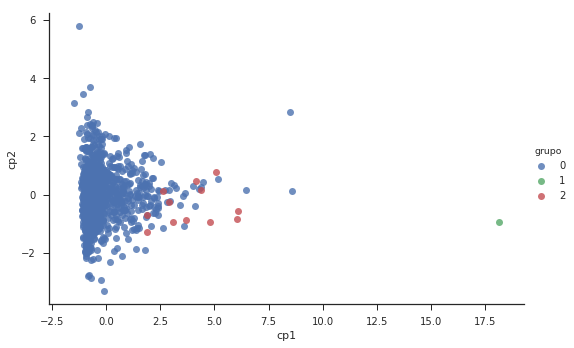

In [124]:
# plotar os escores dos CPs dos 3 grupos
sns.lmplot('cp1', 'cp2', hue='grupo', fit_reg=False, data=resultado, aspect=1.5);

In [125]:
resultado['muni'] = resultado.index

In [126]:
# pacote altair para fazer outros tipos de gráficos
# usaremos para o diagrama de dispersão com a cor de acordo com a mesorregião
import altair as alt
alt.renderers.enable('notebook');
import palettable
# https://vega.github.io/vega/docs/schemes/#reference

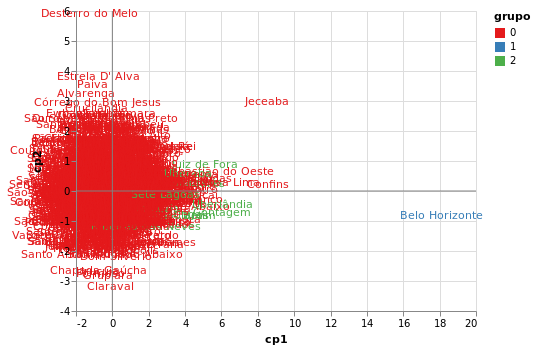

In [127]:
# gráficos
g = alt.Chart(resultado).mark_text().encode(
    alt.X('cp1', scale=alt.Scale(domain=[resultado['cp1'].min(), resultado['cp1'].max()]), axis=alt.Axis(title='cp1')),
    alt.Y('cp2', scale=alt.Scale(domain=[resultado['cp2'].min(), resultado['cp2'].max()]), axis=alt.Axis(title='cp2')),
    text='muni',
    color=alt.Color('grupo:O', scale=alt.Scale(scheme='set1'))
)
# eixo x = 0
bar = alt.Chart(resultado).mark_rule(color='gray').encode(
    x='mean(0):Q')

# eixo y = 0
bar1 = alt.Chart(resultado).mark_rule(color='gray').encode(
    y='mean(0):Q')


g + bar + bar1

Agrupamentos muito próximos dos que foram obtidos com o método de Ward.

### Gráfico k x SQDG

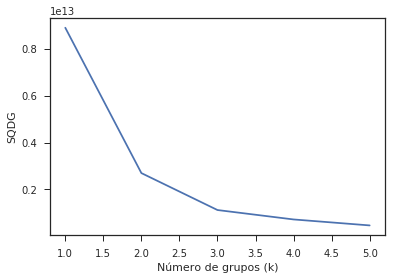

In [128]:
# SQDG
SQDG = {}
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados)
    dados['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

Conclusão: 3 grupos.

## *Silhouette plot*

In [129]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [130]:
# chamando os dados de X para facilitar
X = dados

Para k =  2 Valor do escore médio: 0.98057334296
Para k =  3 Valor do escore médio: 0.892626409821
Para k =  4 Valor do escore médio: 0.709203593459
Para k =  5 Valor do escore médio: 0.496325470712
Para k =  6 Valor do escore médio: 0.510166619276
Para k =  7 Valor do escore médio: 0.42202622021
Para k =  8 Valor do escore médio: 0.434180771118


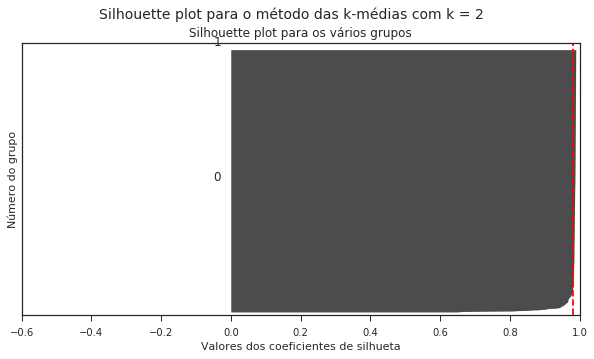

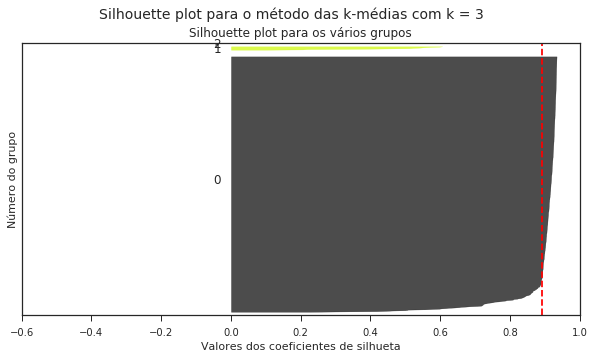

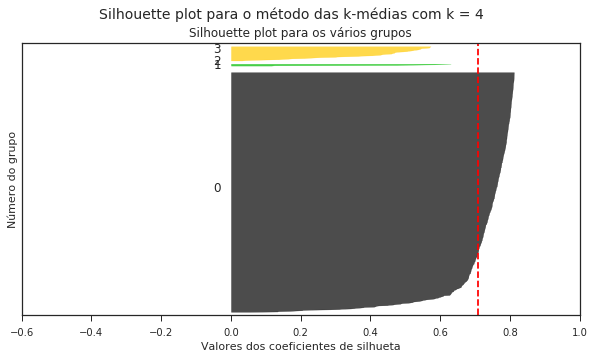

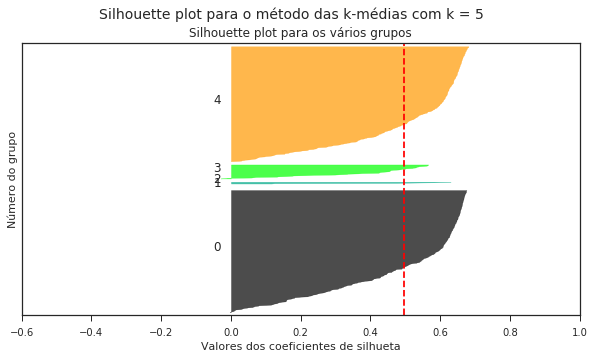

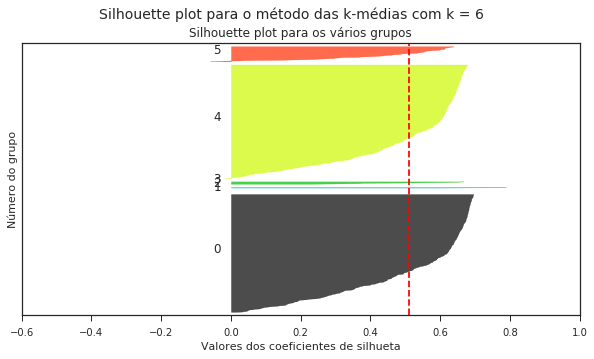

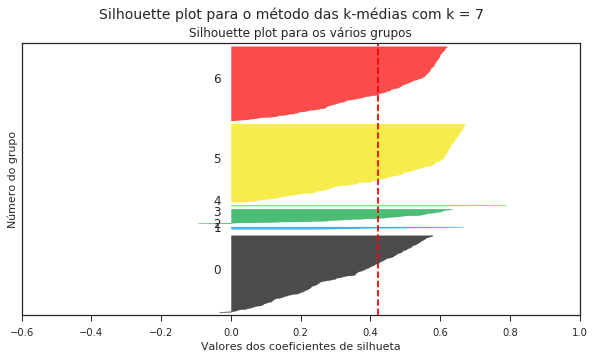

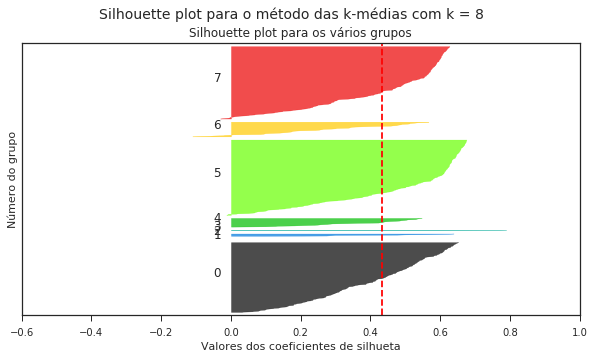

In [131]:
# testando de 2 a 8 grupos
range_n_clusters = list(range(2, 9))
for n_clusters in range_n_clusters:
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 5)

    ax1.set_xlim([-0.5, 1])
    # inserir espaços em branco entre os gráficos
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # valores iniciais aleatórios (10 valores) 
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # o escore dá a média do valor silhueta para todas as amostras
    silhouette_avg = silhouette_score(X, cluster_labels)
    print('Para k = ', n_clusters,
          'Valor do escore médio:', silhouette_avg)

    # calcula os valores dos coeficientes para todas as observações
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # une os escores de silhueta para observações pertencendo ao 
        # grupo i e ordena
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # nomeia os gráficos com seus números de grupos
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # calcula novo valor de y para o próximo gráfico
        y_lower = y_upper + 10

    ax1.set_title('Silhouette plot para os vários grupos')
    ax1.set_xlabel('Valores dos coeficientes de silhueta')
    ax1.set_ylabel('Número do grupo')

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax1.set_yticks([])  # limpa os rótulos dos eixos
    ax1.set_xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(('Silhouette plot para o método das k-médias'
                  ' com k = %d' % n_clusters), fontsize=14);

### Questão 4. b) 

Como ficaria a interpretação desses gráficos?

## Atenção!

A partir dessa célula eu realizo todas as análises novamente, porém selecionando os municípios de uma mesorregião de MG (eu escolhi a Sul/Sudoeste, mas qualquer outra poderia ter sido escolhida).

## Selecionando municípios apenas da mesorregião Sul/Sudoeste de MG

In [132]:
dados2.nome_meso.unique()

array(['Triângulo Mineiro/Alto Paranaíba', 'Central Mineira',
       'Zona da Mata', 'Vale do Rio Doce', 'Oeste de Minas',
       'Vale do Mucuri', 'Norte de Minas', 'Sul/Sudoeste de Minas',
       'Campo das Vertentes', 'Jequitinhonha',
       'Metropolitana de Belo Horizonte', 'Noroeste de Minas'], dtype=object)

In [133]:
meso = dados2.query('nome_meso == "Sul/Sudoeste de Minas"')
meso = meso.reset_index().drop('index', axis=1)

In [134]:
# definindo o index como sendo o nome do município
meso = meso.set_index('nome_mun')

In [135]:
meso.iloc[:,1:5].describe()

,popul,rdpc_formal,tx_mort,prop_priv_saude
count,146.000000,146.000000,146.000000,146.000000
mean,17823.095890,251.649315,7.263493,13.175822
std,25713.583314,139.213318,1.493421,9.671320
min,1703.000000,91.770000,1.450000,1.250000
25%,5402.750000,166.340000,6.492500,5.770000
50%,10287.000000,208.820000,7.035000,10.230000
75%,17737.250000,290.100000,8.047500,17.602500
max,164912.000000,1082.990000,11.560000,47.140000


In [136]:
# médias
meso.iloc[:,1:5].mean()

popul              17823.095890
rdpc_formal          251.649315
tx_mort                7.263493
prop_priv_saude       13.175822
dtype: float64

In [137]:
meso.iloc[:,1:5].cov()

,popul,rdpc_formal,tx_mort,prop_priv_saude
popul,6.611884e+08,2.251341e+06,-3560.395717,156892.585300
rdpc_formal,2.251341e+06,1.938035e+04,-34.830855,887.857738
tx_mort,-3.560396e+03,-3.483085e+01,2.230307,-0.016532
prop_priv_saude,1.568926e+05,8.878577e+02,-0.016532,93.534424


In [138]:
meso.iloc[:,1:5].corr()

,popul,rdpc_formal,tx_mort,prop_priv_saude
popul,1.000000,0.628924,-0.092716,0.630891
rdpc_formal,0.628924,1.000000,-0.167533,0.659442
tx_mort,-0.092716,-0.167533,1.000000,-0.001145
prop_priv_saude,0.630891,0.659442,-0.001145,1.000000


In [139]:
meso.columns

Index(['ibge7', 'popul', 'rdpc_formal', 'tx_mort', 'prop_priv_saude',
       'nome_meso'],
      dtype='object')

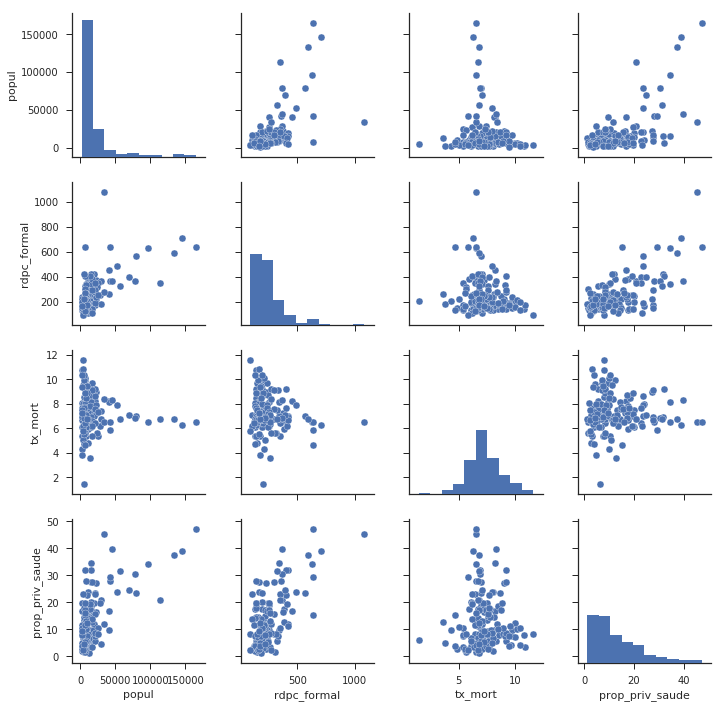

In [140]:
sns.set(style='ticks')
sns.pairplot(meso.iloc[:,1:5]);

### ACP

In [141]:
# subselecionar variáveis
X = meso.iloc[:,1:5]

In [142]:
# ACP
pca = PCA() 
resultado_pca = pca.fit_transform(scale(X))   # scale(X) padroniza os dados, como se usássemos a matriz R

In [143]:
resultado = pd.DataFrame({'cp1':resultado_pca[:, 0], 'cp2':resultado_pca[:, 1]}, index=meso.index)

In [144]:
# coeficientes dos CPs (autovetores)
# cada linha é um CP
print(pca.components_)

[[ 0.56786572  0.58084767 -0.11610492  0.57154542]
 [-0.05600695  0.05094264 -0.97792024 -0.19478213]
 [-0.82013662  0.43391236 -0.00470523  0.37292607]
 [ 0.04204376  0.68683397  0.17369374 -0.70450117]]


In [145]:
# variâncias dos CPs (autovalores)
pca.explained_variance_

array([ 2.31307959,  1.01010788,  0.38246745,  0.32193128])

In [146]:
# variância explicada acumulada
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([  57.43,   82.51,   92.01,  100.  ])

In [147]:
meso.columns

Index(['ibge7', 'popul', 'rdpc_formal', 'tx_mort', 'prop_priv_saude',
       'nome_meso'],
      dtype='object')

In [148]:
# os três primeiros CPs
print(pca.components_[0:3, :])

[[ 0.56786572  0.58084767 -0.11610492  0.57154542]
 [-0.05600695  0.05094264 -0.97792024 -0.19478213]
 [-0.82013662  0.43391236 -0.00470523  0.37292607]]


Interpretação:

- $Y_1$: quanto maior o escore positivo, maiores: tamanho da população, rendimento do setor formal e % de planos de saúde.
- $Y_2$: mais influenciado pela taxa de mortalidade. Quanto maior o escore negativo, maior a taxa de mortalidade. 

In [149]:
# escores dos dois primeiros CPs
resultado.head()

,cp1,cp2
nome_mun,,
Aiuruoca,-1.199928,-1.378355
Alagoa,-0.850382,-0.146456
Albertina,-0.464758,2.044242
Alfenas,3.303670,-0.041023
Alpinópolis,-0.413506,0.622945


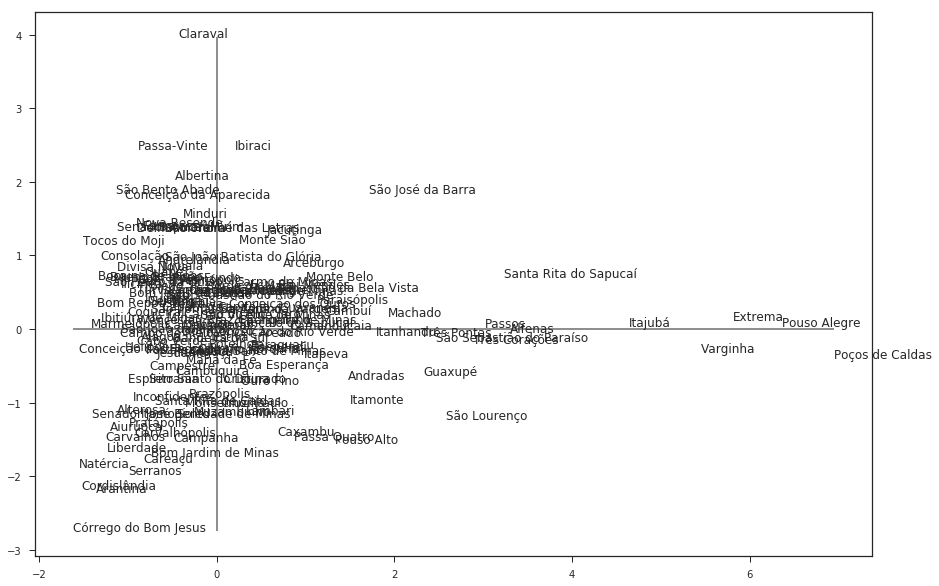

In [150]:
# diagrama de dispersão com os nomes das cidades
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.scatter(resultado.cp1, resultado.cp2, s=0)
for i, txt in enumerate(resultado.index):
    ax.annotate(txt, (resultado.cp1[i], resultado.cp2[i]))
plt.hlines(0, resultado['cp1'].min(), resultado['cp1'].max(), color='gray')
plt.vlines(0, resultado['cp2'].min(), resultado['cp2'].max(), color='gray');

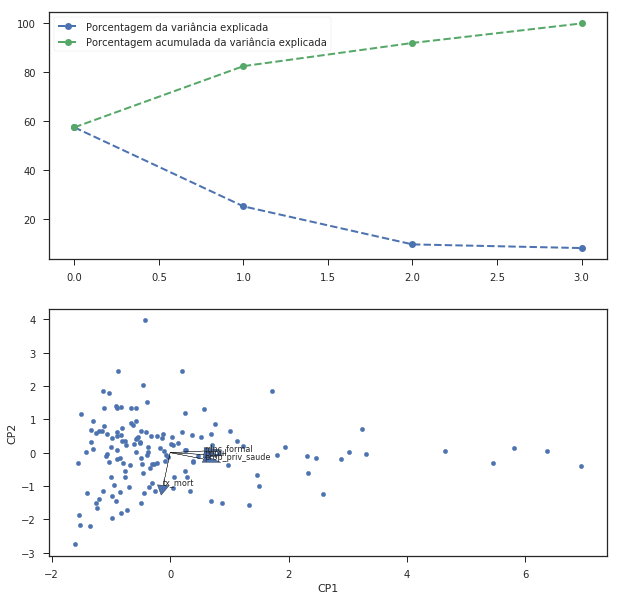

In [151]:
# scree plot e correlações CPs x variáveis
def get_angle(v1, v2):
    # calcula ângulo entre dois vetores
    cosang = np.dot(v1, v2)
    sinang = np.linalg.norm(np.cross(v1, v2))
    return np.degrees(np.arctan2(sinang, cosang))

def annotate_embedding(loadings, pc_x, pc_y, ax, scaling=10, n_features=10, angle_thr=20):
    # função para adicionar loadings no gráfico
    loadings['VectorLength'] = np.sqrt(loadings[pc_x]**2 + loadings[pc_y]**2)
    loadings = loadings.sort_values(by='VectorLength', ascending=False)
    
    # plota cada um dos maiores vetores 
    for feature, row in loadings.iloc[0:n_features].iterrows():
        vector = np.array([row[pc_x]*scaling, row[pc_y]*scaling])
        ax.arrow(0, 0, vector[0], vector[1], head_width=0.2, head_length=0.3)
        ax.annotate(feature, xy=(0, 0), xytext=(vector[0], vector[1]), fontsize=8)
    
    # retorna lista ordenada
    top_features = loadings.index.tolist()
    return top_features

# cria um dataframe com os resultados da ACP
pca_df = pd.DataFrame(
    resultado_pca,
    index=X.index,
    columns=['CP' + str(i + 1) for i in range(resultado_pca.shape[1])]
)

import itertools
# cria dois gráficos
_, axes = plt.subplots(nrows=2, figsize=(10,10))  # número de colunas e tamanho

# plota a variância explicada
axes[0].plot(
    pca.explained_variance_ratio_*100, "--o", linewidth=2,
    label='Porcentagem da variância explicada'
)

# plota a variância explicada acumulada
axes[0].plot(
    (pca.explained_variance_ratio_ * 100).cumsum(), "--o", linewidth=2,
    label='Porcentagem acumulada da variância explicada'
)

# mostra legenda
axes[0].legend(loc='best', frameon=True)
    
# loadings de cada componente
loadings = pd.DataFrame(
    pca.components_,
    index=['CP'+str(i+1) for i in range(len(pca.components_))],
    columns=X.columns
).T

# plota os componentes
i = 1
x, y = 'CP'+str(i), 'CP'+str(i+1)
# plotar
settings = {'kind': 'scatter', 'ax': axes[i], 'alpha': 1, 'x': x, 'y': y}
pca_df.plot(label=None, **settings)
# mostrar os loadings (correlações)
annotate_embedding(loadings, x, y, axes[i], scaling=1, n_features=20, angle_thr=20)
    
# faz aparecer o gráfico
plt.show();

## Selecionar componentes principais

In [152]:
# teste dos coeficientes dos autovetores
for ei in pca.components_:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ei))
print('ok!')

ok!


In [153]:
# lista com autovalores e autovetores
eig_pairs = [(np.abs(pca.explained_variance_[i]), pca.components_[:,i]) for i in range(len(pca.components_))]

# ordenar em ordem decrescente
eig_pairs.sort()
eig_pairs.reverse()

# visualizar autovalores
print('Autovalores em ordem decrescente:')
for i in eig_pairs:
    print(i[0])

Autovalores em ordem decrescente:
2.31307959435
1.01010788483
0.382467450374
0.321931277341


In [154]:
# variãncia explicada acumulada
tot = sum(pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([  57.43091459,   82.51064803,   92.00684329,  100.        ])

In [155]:
# número de CPs gerados (k = p)
cp =['CP'+str(i+1) for i in range(len(pca.components_))]
cp

['CP1', 'CP2', 'CP3', 'CP4']

In [156]:
df = pd.DataFrame({'cp': cp, 'var_exp': var_exp, 'cum_var_exp': cum_var_exp})
df

,cp,var_exp,cum_var_exp
0,CP1,57.430915,57.430915
1,CP2,25.079733,82.510648
2,CP3,9.496195,92.006843
3,CP4,7.993157,100.000000


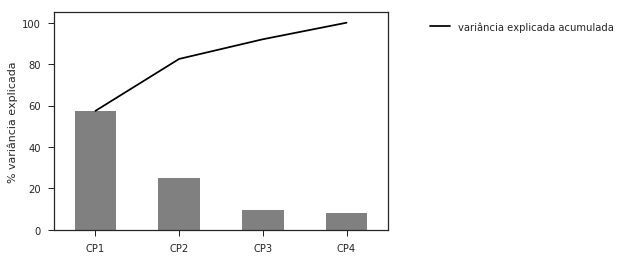

In [157]:
# scree plot
fig, ax = plt.subplots()
df.plot.bar('cp', 'var_exp', color='gray', ax=ax, legend=False)
df.plot.line('cp', 'cum_var_exp', color='black', ax=ax)
plt.legend(labels=['variância explicada acumulada'],
           loc='upper right', 
           bbox_to_anchor=(1.7, 1))
plt.ylabel('% variância explicada')
plt.xlabel('');

### Adicional: incluir a informação da microrregião

In [158]:
# no resultado2 incluir código
resultado2 = resultado

In [159]:
# no dataframe resultado2 incluir os códigos
resultado2['ibge7'] = meso['ibge7'].values

In [160]:
resultado2.head()

,cp1,cp2,ibge7
nome_mun,,,
Aiuruoca,-1.199928,-1.378355,3101201
Alagoa,-0.850382,-0.146456,3101300
Albertina,-0.464758,2.044242,3101409
Alfenas,3.303670,-0.041023,3101607
Alpinópolis,-0.413506,0.622945,3101904


In [161]:
resultado2 = resultado.reset_index()
cod = pd.read_csv('/home/patricia/drive/nupis/dados/codigos-mun.csv')
cod = cod[['mun', 'nome_micro']]
cod.rename(columns={'mun': 'ibge7'}, inplace=True)
# cod = cod.drop_duplicates()

In [162]:
resultado2 = resultado2.merge(cod)

In [163]:
resultado2.head()

,nome_mun,cp1,cp2,ibge7,nome_micro
0,Aiuruoca,-1.199928,-1.378355,3101201,Andrelândia
1,Alagoa,-0.850382,-0.146456,3101300,São Lourenço
2,Albertina,-0.464758,2.044242,3101409,Poços de Caldas
3,Alfenas,3.303670,-0.041023,3101607,Alfenas
4,Alpinópolis,-0.413506,0.622945,3101904,Passos


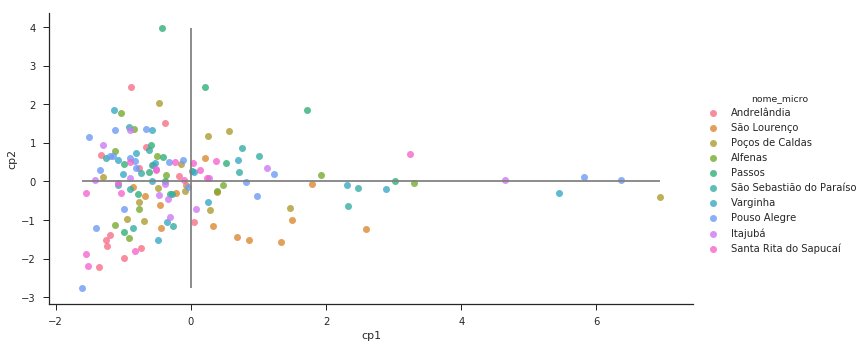

In [164]:
sns.lmplot('cp1', 'cp2', hue='nome_micro', fit_reg=False, data=resultado2, aspect=2)
plt.hlines(0, resultado2['cp1'].min(), resultado2['cp1'].max(), color='gray')
plt.vlines(0, resultado2['cp2'].min(), resultado2['cp2'].max(), color='gray');

In [165]:
import altair as alt
# alt.renderers.enable('notebook');

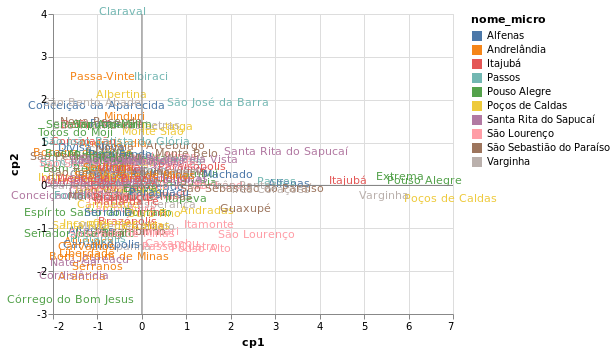

In [166]:
# gráfico
g = alt.Chart(resultado2).mark_text().encode(
    alt.X('cp1', scale=alt.Scale(domain=[resultado2['cp1'].min(), resultado2['cp1'].max()]), axis=alt.Axis(title='cp1')),
    alt.Y('cp2', scale=alt.Scale(domain=[resultado2['cp2'].min(), resultado2['cp2'].max()]), axis=alt.Axis(title='cp2')),
    text='nome_mun',
    color='nome_micro'
)
# eixo x = 0
bar = alt.Chart(resultado2).mark_rule(color='gray').encode(
    alt.X('mean(0):Q'))
# eixo y = 0
bar1 = alt.Chart(resultado2).mark_rule(color='gray').encode(
    y='mean(0):Q')


g + bar + bar1

### Análise de agrupamento

In [167]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [168]:
Z = linkage(X, method='ward')

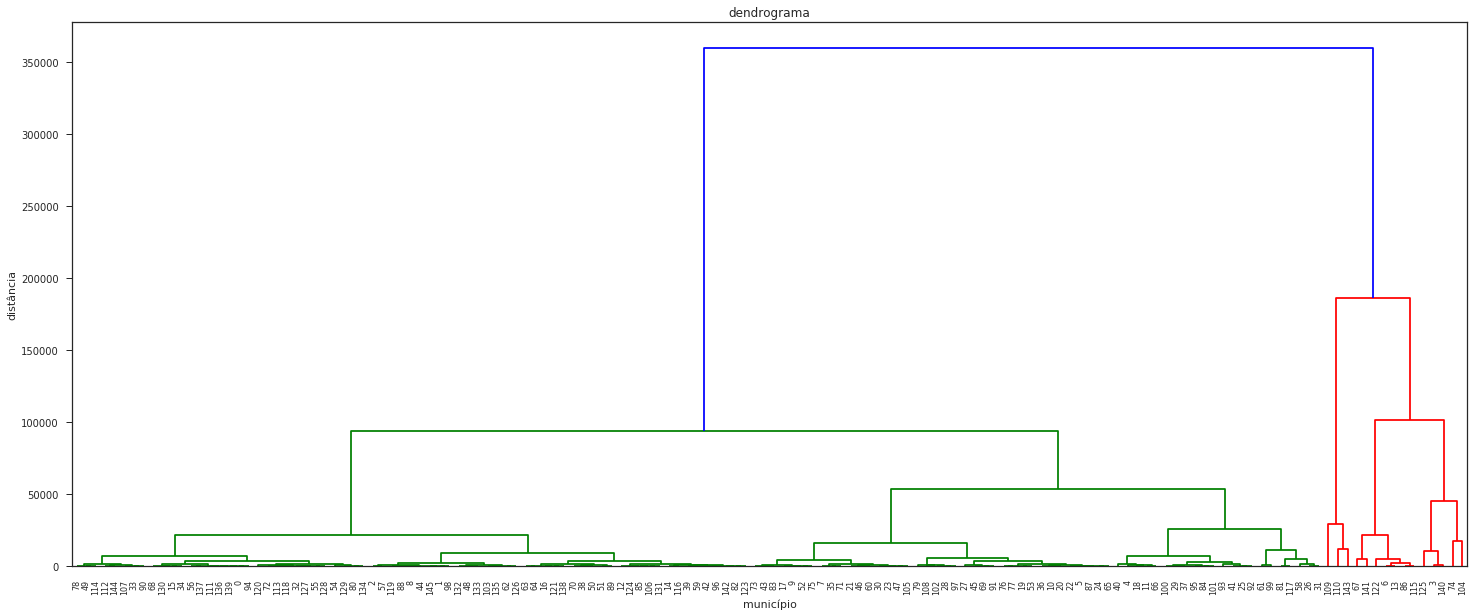

In [169]:
# obter o dendrograma de forma mais automática - função dendrogram
plt.figure(figsize=(25, 10))
plt.title('dendrograma')
plt.xlabel('município')
plt.ylabel('distância')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotação do eixo
    leaf_font_size=8.,  # tamanho da fonte
)
plt.show()

In [170]:
# definir a distância de corte baseando no dendrograma
max_d = 150000

In [171]:
k = 3

In [172]:
# lista com os grupos referentes às observações
from scipy.cluster.hierarchy import cut_tree
grupos = cut_tree(Z, n_clusters=[k])

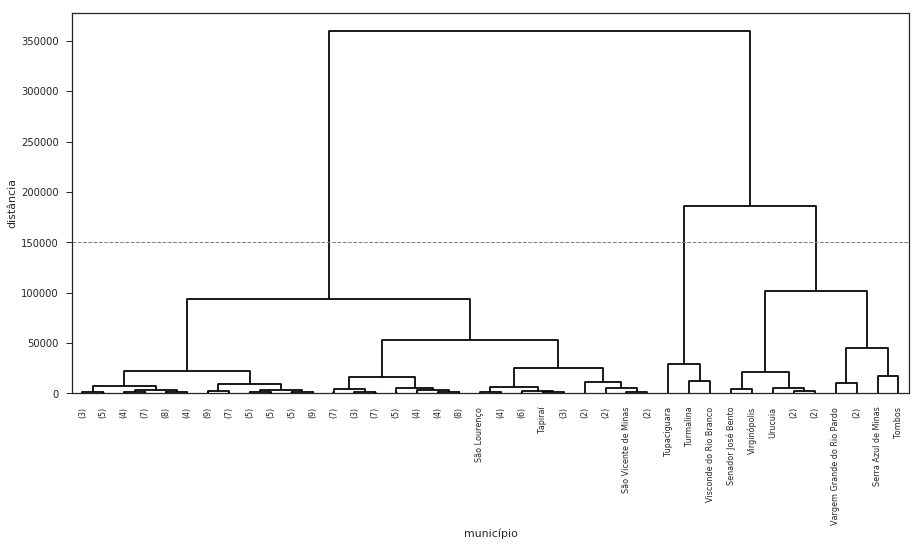

In [173]:
# mostra o ponto de corte na distância max_d
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=40,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=8., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

In [174]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos
resultado['grupo'] = grupos

In [175]:
resultado.shape

(146, 4)

In [176]:
# contagem de observações em cada grupo
resultado.grupo.value_counts()

0    131
1     12
2      3
Name: grupo, dtype: int64

In [177]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
meso['grupo'] = grupos
meso.head()

,ibge7,popul,rdpc_formal,tx_mort,prop_priv_saude,nome_meso,grupo
nome_mun,,,,,,,
Aiuruoca,3101201,6224,195.73,9.64,4.35,Sul/Sudoeste de Minas,0
Alagoa,3101300,2756,189.40,7.62,9.33,Sul/Sudoeste de Minas,0
Albertina,3101409,3040,210.12,4.28,9.87,Sul/Sudoeste de Minas,0
Alfenas,3101607,79222,564.66,6.98,23.47,Sul/Sudoeste de Minas,1
Alpinópolis,3101904,19741,196.97,6.43,8.25,Sul/Sudoeste de Minas,0


In [178]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
meso.iloc[:,1:].groupby('grupo').mean()

,popul,rdpc_formal,tx_mort,prop_priv_saude
grupo,,,,
0,10700.595420,225.949160,7.290840,11.355115
1,63046.916667,433.755833,7.150000,26.041667
2,147943.666667,645.463333,6.523333,41.216667


In [179]:
# mediana das variáveis para cada grupo
meso.iloc[:,1:].groupby('grupo').median()

,popul,rdpc_formal,tx_mort,prop_priv_saude
grupo,,,,
0,8671.0,197.060,7.09,9.59
1,54493.5,383.155,6.93,26.38
2,145535.0,637.830,6.54,39.07


### Questão 4. c) 

Como ficaria a interpretação sobre as variáveis dos três grupos obtidos?
    
-  
-  
-  

In [180]:
# desvio padrão
meso.iloc[:,1:].groupby('grupo').std()

,popul,rdpc_formal,tx_mort,prop_priv_saude
grupo,,,,
0,7194.634555,113.916248,1.555111,7.849885
1,24597.478731,122.888507,0.795362,8.081154
2,15901.413533,60.363075,0.275379,5.194096


## As observações de cada grupo

In [181]:
grupo0 = meso.query('grupo == 0').index
pd.DataFrame(list(grupo0))

,0
0,Aiuruoca
1,Alagoa
2,Albertina
3,Alpinópolis
4,Alterosa
5,Andrelândia
6,Arantina
7,Arceburgo
8,Areado
9,Baependi


In [182]:
grupo1 = meso.query('grupo == 1').index
pd.DataFrame(list(grupo1))

,0
0,Alfenas
1,Andradas
2,Boa Esperança
3,Guaxupé
4,Itajubá
5,Machado
6,Passos
7,Santa Rita do Sapucaí
8,São Lourenço
9,São Sebastião do Paraíso


In [183]:
grupo2 = meso.query('grupo == 2').index
pd.DataFrame(list(grupo2))

,0
0,Poços de Caldas
1,Pouso Alegre
2,Varginha


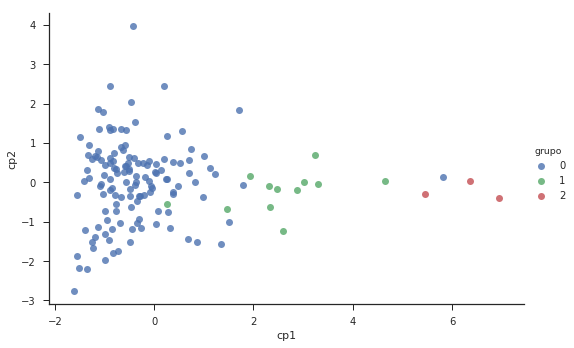

In [184]:
# plotar os escores dos CPs dos 3 grupos
sns.lmplot('cp1', 'cp2', hue='grupo', fit_reg=False, data=resultado, aspect=1.5);

In [185]:
resultado['município'] = resultado.index

In [186]:
# pacote altair para fazer outros tipos de gráficos
# usaremos para o diagrama de dispersão com a cor de acordo com a mesorregião
import altair as alt
alt.renderers.enable('notebook');
# pacote para ter mais opções de paletas de cores
import palettable
# https://vega.github.io/vega/docs/schemes/#reference

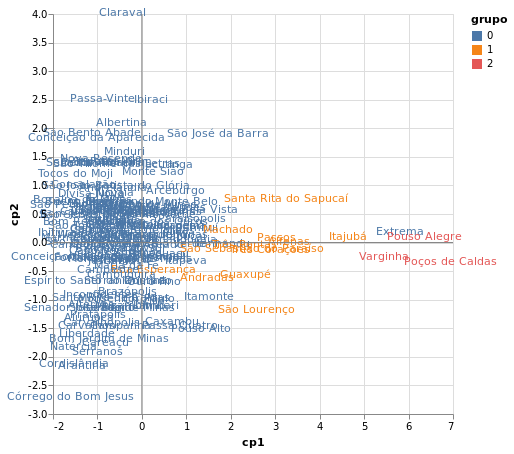

In [187]:
# gráficos
g = alt.Chart(resultado).mark_text().encode(
    alt.X('cp1', scale=alt.Scale(domain=[resultado['cp1'].min(), resultado['cp1'].max()]), axis=alt.Axis(title='cp1')),
    alt.Y('cp2', scale=alt.Scale(domain=[resultado['cp2'].min(), resultado['cp2'].max()]), axis=alt.Axis(title='cp2')),
    text='município',
    color=alt.Color('grupo:O', scale=alt.Scale(scheme='tableau10')),
    # opacity=alt.value(0.6)   # alterar a transparência
).properties(
    width=400, 
    height=400)#.interactive()

# eixo x = 0
bar_x = alt.Chart(resultado).mark_rule(color='gray').encode(
    x='mean(0):Q')

# eixo y = 0
bar_y = alt.Chart(resultado).mark_rule(color='gray').encode(
    y='mean(0):Q')


g + bar_x + bar_y

### Gráfico k x SQDG

Auxilia a decidir em quantos grupos dividir os dados usando o método das $k$-médias. Procurar pelo 'cotovelo' (ponto a partir do qual a queda da SQDG é menor).

In [188]:
dd = meso.iloc[:, 1:5]

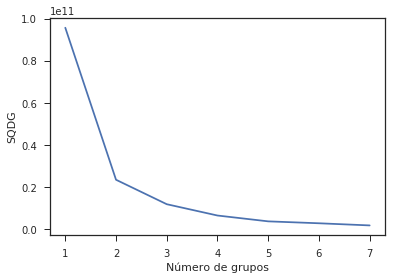

In [189]:
# SQDG
SQDG = {}
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dd)
    dd['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos')
plt.ylabel('SQDG');

Quantos grupos?

-  
- 

## Silhouette plot

In [190]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [191]:
X = dd

For n_clusters = 2 The average silhouette_score is : 0.863389719672
For n_clusters = 3 The average silhouette_score is : 0.766057475868
For n_clusters = 4 The average silhouette_score is : 0.651641956554
For n_clusters = 5 The average silhouette_score is : 0.619024602893
For n_clusters = 6 The average silhouette_score is : 0.620123991166
For n_clusters = 7 The average silhouette_score is : 0.608355082117
For n_clusters = 8 The average silhouette_score is : 0.604007405341


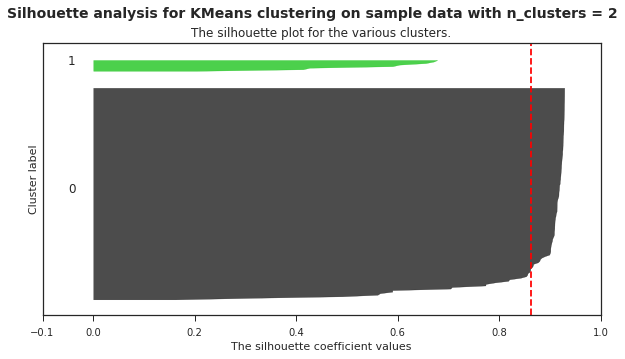

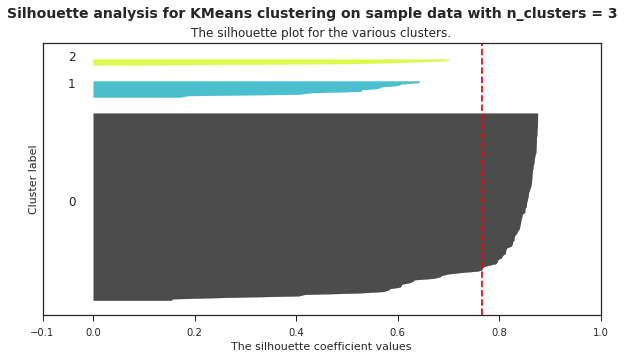

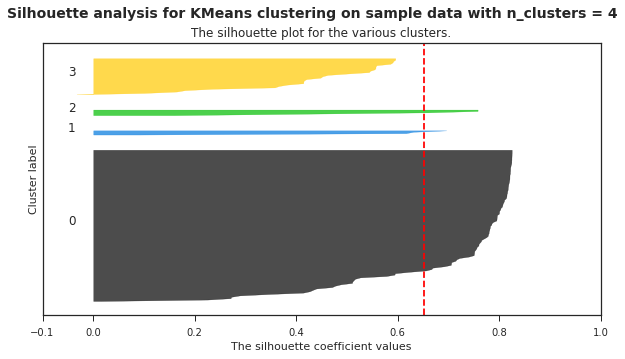

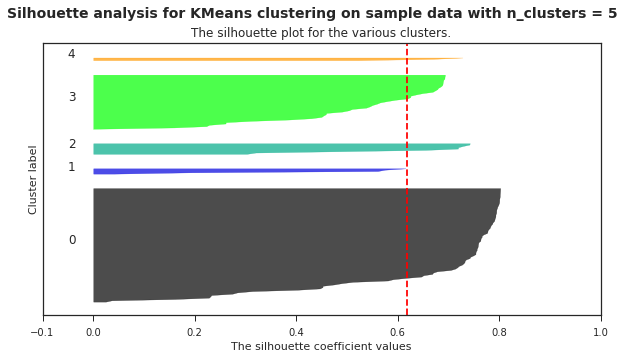

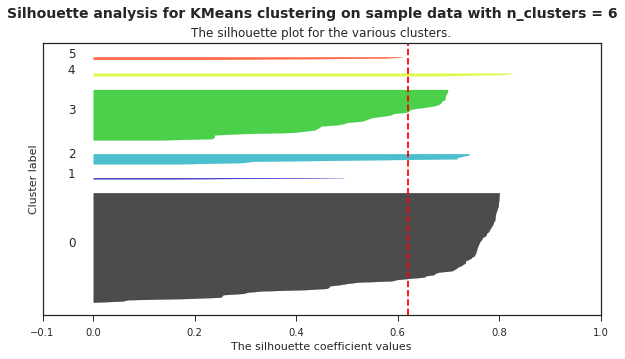

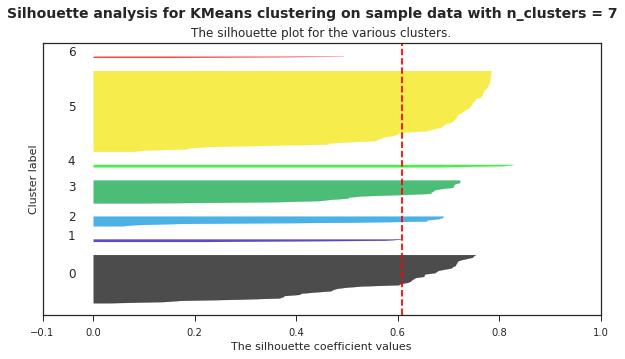

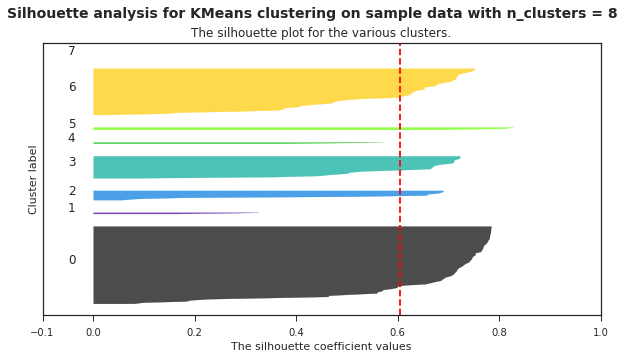

In [192]:
# testando de 2 a 8 grupos
range_n_clusters = list(range(2, 9))
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Questão 4. d) 

Como seria a interpretação dos *silhouette plots* obtidos?

